# Custom NER Corpus

## Importing Libraries

In [1]:
import pandas as pd
import spacy
from spacy.tokens import DocBin
from spacy.training.example import Example
from spacy.util import minibatch
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

## Data loading and inspection

In [2]:
# Load the dataset
file_path = "F:/Career/Applications/AI WideBot/NER/ner.csv"
data = pd.read_csv(file_path)

In [3]:
data.head()

,Sentence #,Sentence,POS,Tag
0,Sentence: 1,Thousands of demonstrators have marched throug...,"['NNS', 'IN', 'NNS', 'VBP', 'VBN', 'IN', 'NNP'...","['O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', '..."
1,Sentence: 2,Families of soldiers killed in the conflict jo...,"['NNS', 'IN', 'NNS', 'VBN', 'IN', 'DT', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
2,Sentence: 3,They marched from the Houses of Parliament to ...,"['PRP', 'VBD', 'IN', 'DT', 'NNS', 'IN', 'NN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
3,Sentence: 4,"Police put the number of marchers at 10,000 wh...","['NNS', 'VBD', 'DT', 'NN', 'IN', 'NNS', 'IN', ...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."
4,Sentence: 5,The protest comes on the eve of the annual con...,"['DT', 'NN', 'VBZ', 'IN', 'DT', 'NN', 'IN', 'D...","['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', ..."


In [4]:
data['Sentence'][6]

'The London march came ahead of anti-war protests today in other cities , including Rome , Paris , and Madrid .'

In [5]:
data['Tag'][6]

"['O', 'B-geo', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'B-geo', 'O', 'B-geo', 'O', 'O', 'B-geo', 'O']"

## EDA

In [6]:
data.shape

(47959, 4)

In [7]:
# checking for duplicates
duplicates_count=data.duplicated().sum()
duplicates_count

0

## Data Preprocessing

### preparing data for the spacy format

In [8]:
# Parse the data
sentences = data['Sentence'].tolist()
pos_tags = data['POS'].apply(eval).tolist()
ner_tags = data['Tag'].apply(eval).tolist()

In [9]:
sentences[0],sentences[0]

('Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .',
 'Thousands of demonstrators have marched through London to protest the war in Iraq and demand the withdrawal of British troops from that country .')

In [10]:
pos_tags[0]

['NNS',
 'IN',
 'NNS',
 'VBP',
 'VBN',
 'IN',
 'NNP',
 'TO',
 'VB',
 'DT',
 'NN',
 'IN',
 'NNP',
 'CC',
 'VB',
 'DT',
 'NN',
 'IN',
 'JJ',
 'NNS',
 'IN',
 'DT',
 'NN',
 '.']

In [11]:
ner_tags[0]

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-geo',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-gpe',
 'O',
 'O',
 'O',
 'O',
 'O']

In [12]:
# Function to convert data into spaCy format
def convert_to_spacy_format(sentences, pos_tags, ner_tags):
    training_data = []
    for sentence, pos, ner in zip(sentences, pos_tags, ner_tags):
        entities = []
        start = 0
        for word, tag in zip(sentence.split(), ner):
            end = start + len(word)
            if tag != 'O':
                entities.append((start, end, tag))
            start = end + 1
        training_data.append((sentence, {"entities": entities}))
    return training_data

In [13]:
# Convert data
training_data = convert_to_spacy_format(sentences, pos_tags, ner_tags)

In [14]:
len(training_data)

47959

### Splitting data into train, validation and test datasets

In [15]:
# Split data into training, validation, and test sets
train_data, temp_data = train_test_split(training_data, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

### Create DocBin (text should be of type doc)

In [16]:
# Function to create a DocBin for training
def create_docbin(training_data, nlp):
    doc_bin = DocBin()
    for text, annot in training_data:
        doc = nlp.make_doc(text)
        example = Example.from_dict(doc, annot)
        doc_bin.add(example.reference)
    return doc_bin

## Model Development

In [17]:
# Load a pre-trained English model (small)
nlp = spacy.load('en_core_web_sm')

In [18]:
# Create the NER component
ner = nlp.get_pipe('ner')

In [19]:
# Add labels
for _, annotations in training_data:
    for ent in annotations.get('entities'):
        ner.add_label(ent[2])

In [20]:
# Create DocBin for training and validation data
train_doc_bin = create_docbin(train_data, nlp)
val_doc_bin = create_docbin(val_data, nlp)

In [21]:
train_doc_bin

### Getting label distribution across datasets

In [22]:
from collections import Counter

# Function to get label distribution
def get_label_distribution(data):
    labels = []
    for text, annot in data:
        for start, end, label in annot['entities']:
            labels.append(label)
    return Counter(labels)


In [23]:
# Get distribution for each dataset
train_distribution = get_label_distribution(train_data)
val_distribution = get_label_distribution(val_data)
test_distribution = get_label_distribution(test_data)

In [24]:
# Convert distribution data to DataFrame
def distribution_to_df(distribution, dataset_name):
    df = pd.DataFrame(distribution.items(), columns=['Label', 'Count'])
    df['Dataset'] = dataset_name
    return df

# Get distributions
train_df = distribution_to_df(train_distribution, 'Training')
val_df = distribution_to_df(val_distribution, 'Validation')
test_df = distribution_to_df(test_distribution, 'Test')

# Combine all into a single DataFrame
df = pd.concat([train_df, val_df, test_df], ignore_index=True)

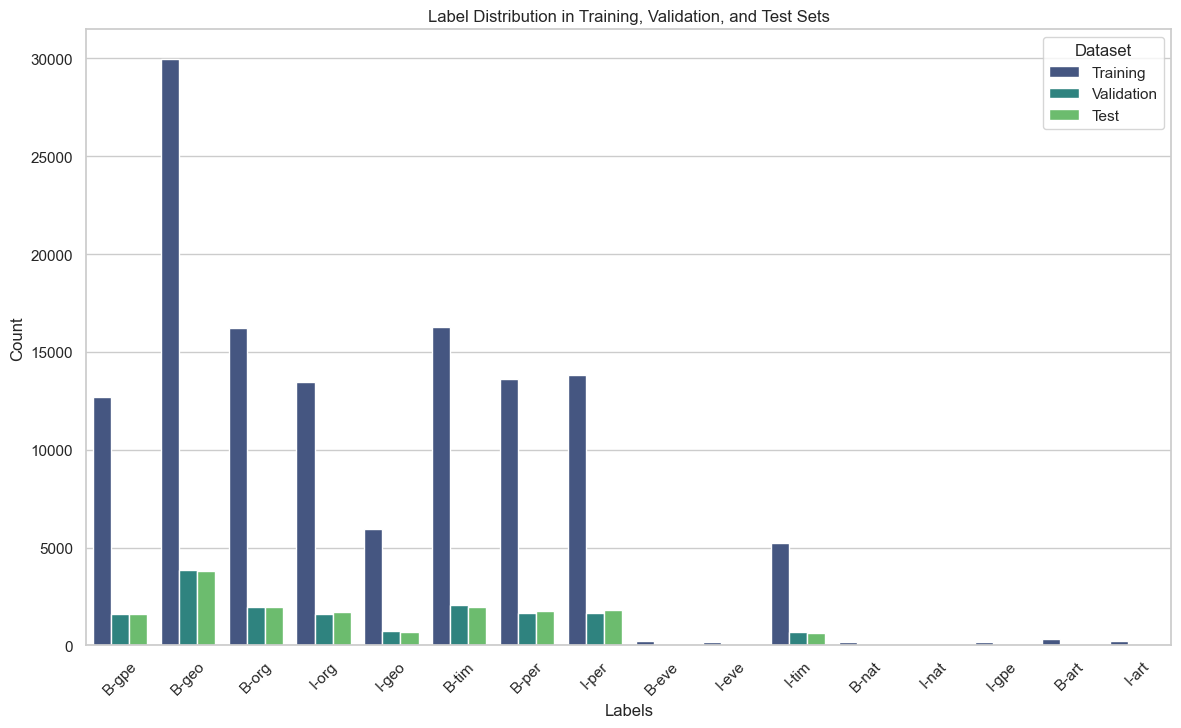

In [25]:
# Set the visual style
sns.set(style="whitegrid")

# Create a bar plot
plt.figure(figsize=(14, 8))
sns.barplot(x='Label', y='Count', hue='Dataset', data=df, palette='viridis')
plt.title('Label Distribution in Training, Validation, and Test Sets')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.legend(title='Dataset')
plt.show()


### Training on our data

In [ ]:
# Training the model
optimizer = nlp.resume_training()

In [27]:
# Fine-tuning the model
for i in range(20):
    losses = {}
    batches = minibatch(train_data, size=8)
    for batch in batches:
        texts, annotations = zip(*batch)
        examples = [Example.from_dict(nlp.make_doc(text), ann) for text, ann in zip(texts, annotations)]
        nlp.update(examples, drop=0.35, losses=losses)
    print(f"Iteration {i}: Losses {losses}")

Iteration 0: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 55515.89073257601}
Iteration 1: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 43384.60596920967}
Iteration 2: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 40376.296136099976}
Iteration 3: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 38106.76491739704}
Iteration 4: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 36558.791205975154}
Iteration 5: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 35531.306866597086}
Iteration 6: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 34756.38233646584}
Iteration 7: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 33848.25059285792}
Iteration 8: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 33226.110549600526}
Iteration 9: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.0, 'ner': 32541.185815206256}
Iteration 10: Losses {'tok2vec': 0.0, 'tagger': 0.0, 'parser': 0.

In [28]:
# Save the trained model
#nlp.to_disk("custom_ner_model")

In [26]:
# Load the trained model
nlp = spacy.load("custom_ner_model")

### Model Evaluation

In [35]:
def evaluate_model(nlp, data):
    results = []
    for text, annot in data:
        doc = nlp(text)
        true_entities = [(start, end, label) for start, end, label in annot['entities']]
        pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in doc.ents]
        results.append((true_entities, pred_entities, text))  # Ensure the tuple is in this format
    return results


In [36]:
# Evaluate on validation set
val_results = evaluate_model(nlp, val_data)
# Evaluate on test set
test_results = evaluate_model(nlp, test_data)

In [37]:
def flatten_results_by_token(nlp, results):
    true_labels = []
    pred_labels = []
    
    for result in results:
        true_entities = result[0]  # Extract true_entities
        pred_entities = result[1]  # Extract pred_entities
        
        true_dict = {(start, end): label for start, end, label in true_entities}
        pred_dict = {(start, end): label for start, end, label in pred_entities}
        
        # Collect all unique start positions
        all_starts = sorted(set([start for start, end in true_dict.keys()] + [start for start, end in pred_dict.keys()]))
        
        for start in all_starts:
            # Use token alignment with start position
            true_label = true_dict.get((start, start+1), 'O')
            pred_label = pred_dict.get((start, start+1), 'O')
            true_labels.append(true_label)
            pred_labels.append(pred_label)
    
    return true_labels, pred_labels


In [39]:
val_true_labels, val_pred_labels = flatten_results_by_token(nlp, val_results)
test_true_labels, test_pred_labels = flatten_results_by_token(nlp, test_results)

In [40]:
from sklearn.metrics import confusion_matrix, precision_recall_curve, average_precision_score,classification_report
# Calculate classification report for validation set
val_report = classification_report(val_true_labels, val_pred_labels, zero_division=1)
print("Validation Classification Report:")
print(val_report)

# Calculate classification report for test set
test_report = classification_report(test_true_labels, test_pred_labels, zero_division=1)
print("Test Classification Report:")
print(test_report)

Validation Classification Report:
              precision    recall  f1-score   support

       B-eve       1.00      0.00      0.00         1
       B-org       1.00      0.00      0.00         3
       B-per       1.00      0.00      0.00         1
       B-tim       1.00      0.50      0.67         8
       I-art       0.00      0.00      1.00         2
       I-eve       0.50      1.00      0.67         1
       I-geo       0.00      0.00      1.00         7
       I-org       0.62      0.40      0.49        25
       I-per       0.67      0.33      0.44         6
       I-tim       0.87      0.85      0.86        65
           O       1.00      1.00      1.00     16451

    accuracy                           1.00     16570
   macro avg       0.70      0.37      0.56     16570
weighted avg       1.00      1.00      1.00     16570

Test Classification Report:
              precision    recall  f1-score   support

       B-eve       1.00      0.00      0.00         1
       B-geo    

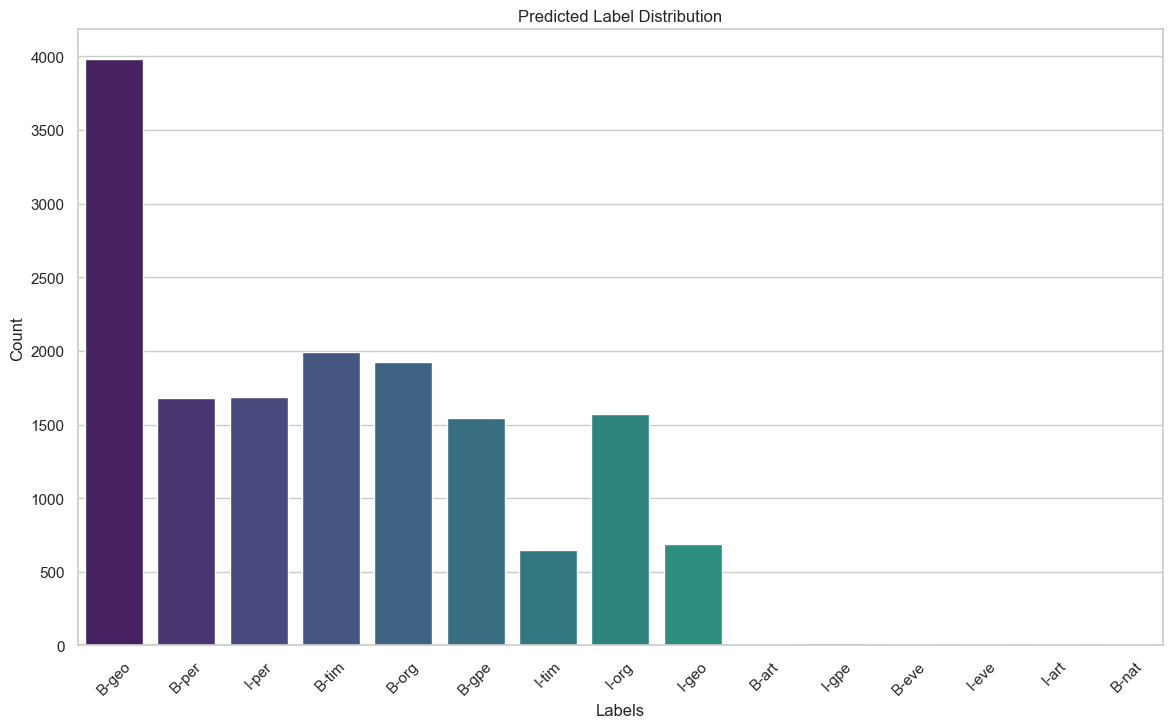

In [73]:
# Extract entity labels from predictions
pred_labels = [ent.label_ for doc in nlp.pipe([text for text, _ in val_data]) for ent in doc.ents]

# Get distribution
pred_distribution = Counter(pred_labels)
pred_df = pd.DataFrame(pred_distribution.items(), columns=['Label', 'Count'])

# Plot distribution
plt.figure(figsize=(14, 8))
sns.barplot(x='Label', y='Count', data=pred_df, palette='viridis')
plt.title('Predicted Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()


In [72]:
from spacy import displacy

def visualize_entities_with_displacy(text, true_entities, pred_entities):
    doc = nlp(text)
    
    # Set up colors
    colors = {
    "B-eve": "#ff9999",
    "B-geo": "#66b3ff",
    "B-org": "#99ff99",
    "B-tim": "#ffcc99",
    "I-art": "#c2c2f0",
    "I-eve": "#ffb3e6",
    "I-geo": "#c2f0c2",
    "I-org": "#c4e17f",
    "I-per": "#ffb3b3",
    "I-tim": "#b3b3b3"
    }
    
    # Create annotations for true entities
    true_annotations = {"entities": true_entities}
    
    # Render true entities
    print("True Entities:")
    displacy.render(doc, style="ent", options={"colors": colors})

    # Create a new Doc object for predictions
    doc_pred = nlp(text)
    doc_pred.ents = [doc_pred.char_span(start, end, label) for start, end, label in pred_entities]
    
    # Render predicted entities
    print("Predicted Entities:")
    displacy.render(doc_pred, style="ent", options={"colors": colors})

# Example usage
for text, annot in val_data[3:5]:
    true_entities = annot['entities']
    pred_entities = [(ent.start_char, ent.end_char, ent.label_) for ent in nlp(text).ents]
    if true_entities or pred_entities:  # Plot only if there are entities to show
        visualize_entities_with_displacy(text, true_entities, pred_entities)
    else:
        print("No entities found in this example.")


True Entities:


Predicted Entities:


True Entities:


Predicted Entities:
